In [ ]:
#@title Installs:

!pip install pretrainedmodels

!pip install torchlm

In [ ]:
!pip install wandb
!wandb login 22ed476c0b9f3220c32f86c9de19e34fe91112cf

In [15]:
#!unzip "drive/MyDrive/dataset_1000.zip"
!unzip "drive/MyDrive/data/300W.zip"

Archive:  drive/MyDrive/data/300W.zip
  inflating: 300W/02_Outdoor/outdoor_186.pts  
  inflating: 300W/02_Outdoor/outdoor_154.pts  
  inflating: 300W/02_Outdoor/outdoor_297.pts  
  inflating: 300W/02_Outdoor/outdoor_296.pts  
  inflating: 300W/02_Outdoor/outdoor_274.pts  
  inflating: 300W/02_Outdoor/outdoor_299.pts  
  inflating: 300W/02_Outdoor/outdoor_277.pts  
  inflating: 300W/02_Outdoor/outdoor_271.pts  
  inflating: 300W/02_Outdoor/outdoor_101.pts  
  inflating: 300W/02_Outdoor/outdoor_289.pts  
  inflating: 300W/02_Outdoor/outdoor_132.pts  
  inflating: 300W/02_Outdoor/outdoor_268.pts  
  inflating: 300W/02_Outdoor/outdoor_153.pts  
  inflating: 300W/02_Outdoor/outdoor_030.pts  
  inflating: 300W/02_Outdoor/outdoor_069.pts  
  inflating: 300W/02_Outdoor/outdoor_008.pts  
  inflating: 300W/02_Outdoor/outdoor_111.pts  
  inflating: 300W/02_Outdoor/outdoor_267.pts  
  inflating: 300W/02_Outdoor/outdoor_291.pts  
  inflating: 300W/02_Outdoor/outdoor_288.pts  
  inflating: 300W/02_O

In [ ]:
!unzip "drive/MyDrive/data/dataset_10000.zip"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#@title Import:

import torch
import os
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.utils.data as data
import scipy
import torch.nn.functional as F
import torchvision.transforms as T

import pretrainedmodels
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import torch.optim as one
import matplotlib
import random
import time
import logging
import torchlm
import wandb


from PIL import Image, ImageFilter
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchvision import transforms
from scipy.integrate import simps
from scipy.stats import norm
from math import floor

In [6]:
#@title Configuration:

class Config():
    def __init__(self):
        self.det_head = 'pip'
        self.net_stride = 32
        self.batch_size = 16
        self.init_lr = 0.0001
        self.num_epochs = 55
        self.decay_steps = [30, 50]
        self.input_size = 256
        self.backbone = 'resnet18'
        self.pretrained = True
        self.criterion_cls = 'l2'
        self.criterion_reg = 'l1'
        self.cls_loss_weight = 10
        self.reg_loss_weight = 1
        self.num_lms = 68
        self.save_interval = 2
        self.num_nb = 10
        self.use_gpu = True
        self.gpu_id = 0
        self.data_dir = "dataset_100000/"
        self.test_data_dir = "300W"
        self.log_dir = "drive/MyDrive/machine-learning/"
        self.data_name = "pipnet_rn18/"
        self.experiment_name = None



cfg = Config()
cfg.experiment_name = "09"

In [7]:
#@title Data (Augmentation) Methods:

# Augmentation methods:
def random_translate(image, target, override = False):

    if override == True or random.random() > 0.5:
        image_height, image_width = image.size
        a = 1
        b = 0
        #c = 30 #left/right (i.e. 5/-5)
        c = int((random.random()-0.5) * 60)
        d = 0
        e = 1
        #f = 30 #up/down (i.e. 5/-5)
        f = int((random.random()-0.5) * 60)
        image = image.transform(image.size, Image.AFFINE, (a, b, c, d, e, f))
        target_translate = target.copy()
        target_translate = target_translate.reshape(-1, 2)
        target_translate[:, 0] -= 1.*c/image_width
        target_translate[:, 1] -= 1.*f/image_height
        target_translate = target_translate.flatten()
        target_translate[target_translate < 0] = 0
        target_translate[target_translate > 1] = 1
        return image, target_translate
    else:
        return image, target

def random_blur(image, override = False):
    if override == True or random.random() > 0.7:
        image = image.filter(ImageFilter.GaussianBlur(random.random()*5))
    return image

def random_occlusion(image, override = False):
    if override == True or random.random() > 0.5:
        image_np = np.array(image).astype(np.uint8)
        image_np = image_np[:,:,::-1]
        image_height, image_width, _ = image_np.shape
        occ_height = int(image_height*0.4*random.random())
        occ_width = int(image_width*0.4*random.random())
        occ_xmin = int((image_width - occ_width - 10) * random.random())
        occ_ymin = int((image_height - occ_height - 10) * random.random())
        image_np[occ_ymin:occ_ymin+occ_height, occ_xmin:occ_xmin+occ_width, 0] = int(random.random() * 255)
        image_np[occ_ymin:occ_ymin+occ_height, occ_xmin:occ_xmin+occ_width, 1] = int(random.random() * 255)
        image_np[occ_ymin:occ_ymin+occ_height, occ_xmin:occ_xmin+occ_width, 2] = int(random.random() * 255)
        image_pil = Image.fromarray(image_np[:,:,::-1].astype('uint8'), 'RGB')
        return image_pil
    else:
        return image

def random_rotate(image, target, angle_max, override = False):
    if override == True or random.random() > 0.5:
        center_x = 0.5
        center_y = 0.5
        landmark_num= int(len(target) / 2)
        target_center = np.array(target) - np.array([center_x, center_y]*landmark_num)
        target_center = target_center.reshape(landmark_num, 2)
        theta_max = np.radians(angle_max)
        theta = random.uniform(-theta_max, theta_max)
        angle = np.degrees(theta)
        image = image.rotate(angle)

        c, s = np.cos(theta), np.sin(theta)
        rot = np.array(((c,-s), (s, c)))
        target_center_rot = np.matmul(target_center, rot)
        target_rot = target_center_rot.reshape(landmark_num*2) + np.array([center_x, center_y]*landmark_num)
        return image, target_rot
    else:
        return image, target

def gen_target_pip(target, meanface_indices, target_map, target_local_x, target_local_y, target_nb_x, target_nb_y):
    num_nb = len(meanface_indices[0])
    map_channel, map_height, map_width = target_map.shape
    target = target.reshape(-1, 2)
    assert map_channel == target.shape[0]

    for i in range(map_channel):
        mu_x = int(floor(target[i][0] * map_width))
        mu_y = int(floor(target[i][1] * map_height))
        mu_x = max(0, mu_x)
        mu_y = max(0, mu_y)
        mu_x = min(mu_x, map_width-1)
        mu_y = min(mu_y, map_height-1)
        target_map[i, mu_y, mu_x] = 1
        shift_x = target[i][0] * map_width - mu_x
        shift_y = target[i][1] * map_height - mu_y
        target_local_x[i, mu_y, mu_x] = shift_x
        target_local_y[i, mu_y, mu_x] = shift_y

        for j in range(num_nb):
            nb_x = target[meanface_indices[i][j]][0] * map_width - mu_x
            nb_y = target[meanface_indices[i][j]][1] * map_height - mu_y
            target_nb_x[num_nb*i+j, mu_y, mu_x] = nb_x
            target_nb_y[num_nb*i+j, mu_y, mu_x] = nb_y

    return target_map, target_local_x, target_local_y, target_nb_x, target_nb_y


In [8]:
#@title Dataset:

class ImageFolder_pip(data.Dataset):
    def __init__(self, root, imgs, input_size, num_lms, net_stride, meanface_indices, is_training = False, transform=None, target_transform=None):
        self.root = root
        self.imgs = imgs
        self.num_lms = num_lms
        self.net_stride = net_stride
        self.meanface_indices = meanface_indices
        self.num_nb = len(meanface_indices[0])
        self.transform = transform
        self.target_transform = target_transform
        self.input_size = input_size
        self.is_training = is_training

    def __getitem__(self, index):

        img_name, target = self.imgs[index]

        img = Image.open(img_name).convert('RGB')
        

        if self.is_training:
          img, target = random_translate(img, target)
          img = random_occlusion(img)
          img, target = random_rotate(img, target, 30)
          img = random_blur(img)

        target_map = np.zeros((self.num_lms, int(self.input_size/self.net_stride), int(self.input_size/self.net_stride)))
        target_local_x = np.zeros((self.num_lms, int(self.input_size/self.net_stride), int(self.input_size/self.net_stride)))
        target_local_y = np.zeros((self.num_lms, int(self.input_size/self.net_stride), int(self.input_size/self.net_stride)))
        target_nb_x = np.zeros((self.num_nb*self.num_lms, int(self.input_size/self.net_stride), int(self.input_size/self.net_stride)))
        target_nb_y = np.zeros((self.num_nb*self.num_lms, int(self.input_size/self.net_stride), int(self.input_size/self.net_stride)))
        target_map, target_local_x, target_local_y, target_nb_x, target_nb_y = gen_target_pip(target, self.meanface_indices, target_map, target_local_x, target_local_y, target_nb_x, target_nb_y)
        
        target_map = torch.from_numpy(target_map).float()
        target_local_x = torch.from_numpy(target_local_x).float()
        target_local_y = torch.from_numpy(target_local_y).float()
        target_nb_x = torch.from_numpy(target_nb_x).float()
        target_nb_y = torch.from_numpy(target_nb_y).float()

        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target_map = self.target_transform(target_map)
            target_local_x = self.target_transform(target_local_x)
            target_local_y = self.target_transform(target_local_y)
            target_nb_x = self.target_transform(target_nb_x)
            target_nb_y = self.target_transform(target_nb_y)
        
        return img, target_map, target_local_x, target_local_y, target_nb_x, target_nb_y, target

    def __len__(self):
        return len(self.imgs)

In [12]:
#@title Data Annotation:

def generate_meanface():
    custom_meanface, custom_meanface_string = torchlm.data.annotools.generate_meanface(
      annotation_path="data_annotated.txt",
      coordinates_already_normalized=True)
    
    with open('meanface.txt', 'w') as f:
      f.writelines(custom_meanface_string)

    rendered_meanface = torchlm.data.annotools.draw_meanface(
      meanface=custom_meanface, coordinates_already_normalized=True)
    
    cv2.imwrite("meanface.jpg", rendered_meanface)
    
    #print(custom_meanface_string)

def get_keypoints(data_dir, file_name):
    #remove file extension from file_name
    idx = [idx for idx, x in enumerate(file_name) if x == '.']
    file_name = file_name[:idx[0]]
    #get name of keypoint file
    file_name = data_dir + file_name + "_ldmks.txt"
    #fetch file and extract keypoints as list of tuples
    keypoints = pd.read_csv(file_name, sep=" ", header=None, names=range(1,3))
    keypoints = np.array(keypoints, dtype='float32')

    return keypoints

def get_keypoints_path(file_path):

    idx = [idx for idx, x in enumerate(file_path) if x == '.']
    file_name = file_path[:idx[0]]
    file_name = str(file_name) + "_ldmks.txt"
    keypoints = pd.read_csv(file_name, sep=" ", header=None, names=range(1,3))
    keypoints = np.array(keypoints, dtype='float32')

    return keypoints



def form_datafile():
  # get all images in list:
  #im_list = np.array([])
  #for f in os.listdir(cfg.data_dir):
  #  if not '_seg' in f and not '_ldmks' in f and '.png' in f:
  #    im_list = np.append(im_list, f)

  train_list, valid_list = train_validate_split(cfg.data_dir, 0.1)

  lines = []
  for i in range(0, train_list.shape[0]):
    keypoints = get_keypoints(cfg.data_dir, train_list[i])
    keypoints = keypoints[:-2, :]
    keypoints = keypoints/512 # normalize coordinates
    keypoints = np.reshape(keypoints, (1, keypoints.shape[0]*2))
    line = ""
    for j in range(0, keypoints.shape[1]):
      val = keypoints[0,j]
      val = str(val)
      line += (" " + val) 

    if i == 0:
      lines.append(str(cfg.data_dir + train_list[i]) + line)
    else:
      lines.append("\n" + str(cfg.data_dir + train_list[i]) + line)
      
  with open('data_annotated.txt', 'w') as f:
    f.writelines(lines)


  lines = []
  for i in range(0, valid_list.shape[0]):
    keypoints = get_keypoints(cfg.data_dir, valid_list[i])
    keypoints = keypoints[:-2, :]
    keypoints = keypoints/512 # normalize coordinates
    keypoints = np.reshape(keypoints, (1, keypoints.shape[0]*2))
    line = ""
    for j in range(0, keypoints.shape[1]):
      val = keypoints[0,j]
      val = str(val)
      line += (" " + val) 

    if i == 0:
      lines.append(str(cfg.data_dir + valid_list[i]) + line)
    else:
      lines.append("\n" + str(cfg.data_dir + valid_list[i]) + line)
      
  with open('data_annotated_validation.txt', 'w') as f:
    f.writelines(lines)



form_datafile()
generate_meanface()

Generating meanface [data_annotated.txt]: 100%|██████████| 9001/9001 [00:00<00:00, 25782.41it/s]


In [9]:
#@title Visualization
def show_points_validation(image, target, lms):
  target = target.cuda().detach().cpu().clone().numpy()
  image = image.cuda().detach().cpu().clone()
  img = np.array(image, dtype='float32')
  img = np.transpose(img,(1,2,0))

  plt.imshow(img)
  target = np.reshape(target,(len(target)//2, 2))
  plt.plot(target[:,0]*cfg.input_size,target[:,1]*cfg.input_size, 'bo', markersize=2)


  preds = lms.cuda().detach().cpu().clone().numpy()
  preds = np.reshape(preds, (len(preds)//2, 2))
  plt.plot(preds[:,0]*cfg.input_size,preds[:,1]*cfg.input_size, 'ro', markersize=2)


  plt.show()
  return



def dataset_keypoints_plot(data):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        image, labels_map, labels_x, labels_y, labels_nb_x, labels_nb_y, target = data[i]

        img = np.array(image, dtype='float32')
        img = np.transpose(img,(1,2,0))

        plt.imshow(img)
        target = np.reshape(target,(len(target)//2, 2))
        plt.plot(target[:,0]*cfg.input_size,target[:,1]*cfg.input_size, 'bo', markersize=2)
        plt.show()



In [13]:
#@title Utility Functions:
def train_validate_split(folder_path, split):
  im_list = np.array([])
  for f in os.listdir(folder_path):
    if not '_seg' in f and not '_ldmks' in f and '.png' in f:
      im_list = np.append(im_list, f)
  len_data = len(im_list)
  # calculate the validation data sample length
  valid_split = int(len_data * split)
  # calculate the training data samples length
  train_split = int(len_data - valid_split)
  training_samples = im_list[:train_split]
  valid_samples = im_list[-valid_split:]
  return training_samples, valid_samples

def get_label(label_file, task_type=None):
    label_path = label_file
    with open(label_path, 'r') as f:
        labels = f.readlines()
    labels = [x.strip().split() for x in labels]
    if len(labels[0])==1:
        return labels

    labels_new = []
    for label in labels:
        image_name = label[0]
        target = label[1:]
        target = np.array([float(x) for x in target])
        if task_type is None:
            labels_new.append([image_name, target])
        else:
            labels_new.append([image_name, task_type, target])
    return labels_new

def get_meanface(meanface_file, num_nb):
    with open(meanface_file) as f:
        meanface = f.readlines()[0]
        
    meanface = meanface.strip().split()
    meanface = [float(x) for x in meanface]
    meanface = np.array(meanface).reshape(-1, 2)
    # each landmark predicts num_nb neighbors
    meanface_indices = []
    for i in range(meanface.shape[0]):
        pt = meanface[i,:]
        dists = np.sum(np.power(pt-meanface, 2), axis=1)
        indices = np.argsort(dists)
        meanface_indices.append(indices[1:1+num_nb])
    
    # each landmark predicted by X neighbors, X varies
    meanface_indices_reversed = {}
    for i in range(meanface.shape[0]):
        meanface_indices_reversed[i] = [[],[]]
    for i in range(meanface.shape[0]):
        for j in range(num_nb):
            meanface_indices_reversed[meanface_indices[i][j]][0].append(i)
            meanface_indices_reversed[meanface_indices[i][j]][1].append(j)
    
    max_len = 0
    for i in range(meanface.shape[0]):
        tmp_len = len(meanface_indices_reversed[i][0])
        if tmp_len > max_len:
            max_len = tmp_len
    
    # tricks, make them have equal length for efficient computation
    for i in range(meanface.shape[0]):
        tmp_len = len(meanface_indices_reversed[i][0])
        meanface_indices_reversed[i][0] += meanface_indices_reversed[i][0]*10
        meanface_indices_reversed[i][1] += meanface_indices_reversed[i][1]*10
        meanface_indices_reversed[i][0] = meanface_indices_reversed[i][0][:max_len]
        meanface_indices_reversed[i][1] = meanface_indices_reversed[i][1][:max_len]

    # make the indices 1-dim
    reverse_index1 = []
    reverse_index2 = []
    for i in range(meanface.shape[0]):
        reverse_index1 += meanface_indices_reversed[i][0]
        reverse_index2 += meanface_indices_reversed[i][1]
    return meanface_indices, reverse_index1, reverse_index2, max_len

def compute_loss_pip(outputs_map, outputs_local_x, outputs_local_y, outputs_nb_x, outputs_nb_y, labels_map, labels_local_x, labels_local_y, labels_nb_x, labels_nb_y,  criterion_cls, criterion_reg, num_nb):

    tmp_batch, tmp_channel, tmp_height, tmp_width = outputs_map.size()
    labels_map = labels_map.view(tmp_batch*tmp_channel, -1)
    labels_max_ids = torch.argmax(labels_map, 1)
    labels_max_ids = labels_max_ids.view(-1, 1)
    labels_max_ids_nb = labels_max_ids.repeat(1, num_nb).view(-1, 1)

    outputs_local_x = outputs_local_x.view(tmp_batch*tmp_channel, -1)
    outputs_local_x_select = torch.gather(outputs_local_x, 1, labels_max_ids)
    outputs_local_y = outputs_local_y.view(tmp_batch*tmp_channel, -1)
    outputs_local_y_select = torch.gather(outputs_local_y, 1, labels_max_ids)
    outputs_nb_x = outputs_nb_x.view(tmp_batch*num_nb*tmp_channel, -1)
    outputs_nb_x_select = torch.gather(outputs_nb_x, 1, labels_max_ids_nb)
    outputs_nb_y = outputs_nb_y.view(tmp_batch*num_nb*tmp_channel, -1)
    outputs_nb_y_select = torch.gather(outputs_nb_y, 1, labels_max_ids_nb)

    labels_local_x = labels_local_x.view(tmp_batch*tmp_channel, -1)
    labels_local_x_select = torch.gather(labels_local_x, 1, labels_max_ids)
    labels_local_y = labels_local_y.view(tmp_batch*tmp_channel, -1)
    labels_local_y_select = torch.gather(labels_local_y, 1, labels_max_ids)
    labels_nb_x = labels_nb_x.view(tmp_batch*num_nb*tmp_channel, -1)
    labels_nb_x_select = torch.gather(labels_nb_x, 1, labels_max_ids_nb)
    labels_nb_y = labels_nb_y.view(tmp_batch*num_nb*tmp_channel, -1)
    labels_nb_y_select = torch.gather(labels_nb_y, 1, labels_max_ids_nb)

    labels_map = labels_map.view(tmp_batch, tmp_channel, tmp_height, tmp_width)
    loss_map = criterion_cls(outputs_map, labels_map)
    loss_x = criterion_reg(outputs_local_x_select, labels_local_x_select)
    loss_y = criterion_reg(outputs_local_y_select, labels_local_y_select)
    loss_nb_x = criterion_reg(outputs_nb_x_select, labels_nb_x_select)
    loss_nb_y = criterion_reg(outputs_nb_y_select, labels_nb_y_select)
    return loss_map, loss_x, loss_y, loss_nb_x, loss_nb_y

def train_model(det_head, net, train_loader, valid_loader, criterion_cls, criterion_reg, cls_loss_weight, reg_loss_weight, num_nb, optimizer, num_epochs, scheduler, save_dir, save_interval, device):
    nmes = []
    losses = []
    val_losses = []
    wandb.init(project="pipnet18_domain_gap", name="pipnet18-10000-full", id="pip09", resume="must")
    wandb.config = {
      "learning_rate": cfg.init_lr,
      "epochs": num_epochs,
      "batch_size": cfg.batch_size
    }
    wandb.watch(net, criterion_cls, log="all", log_freq=1) #TODO might want to change log_freq?

    epoch_start = 48

    for epoch in range(epoch_start, num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        logging.info('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        logging.info('-' * 10)
        epoch_loss = 0.0
 
        epoch_loss = fit(net, train_loader, criterion_cls, criterion_reg, cls_loss_weight, reg_loss_weight, num_nb, optimizer, epoch, num_epochs)
        validation_loss, nme = validate(net, valid_loader, criterion_cls, criterion_reg, cls_loss_weight, reg_loss_weight, num_nb, optimizer, epoch, num_epochs)

        losses.append(epoch_loss)
        val_losses.append(validation_loss)
        nmes.append(nme)

        wandb.log({"epoch": (epoch+1),
               "train_loss": (epoch_loss),
               "val_loss": (validation_loss),
               "NME": (nme)})
        wandb.define_metric("epoch")

        if epoch%(save_interval-1) == 0 and epoch > 0:
            filename = os.path.join(save_dir, 'epoch%d.pth' % epoch)
            torch.save(net.state_dict(), filename)
            print(filename, 'saved')
        scheduler.step()

    
    plt.figure(figsize=(10, 7))
    plt.plot(losses, color='orange', label='train loss')
    plt.plot(val_losses, color='red', label='validataion loss')
    plt.plot(nmes, color='blue', label='NME')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return net

def fit(net, train_loader, criterion_cls, criterion_reg, cls_loss_weight, reg_loss_weight, num_nb, optimizer, epoch, num_epochs):
    print('Training')
    training_loss = 0.0
    net.train()
    for i, data in enumerate(train_loader):
      
        inputs, labels_map, labels_x, labels_y, labels_nb_x, labels_nb_y, target = data
        target = target.to(device)
        inputs = inputs.to(device)
        labels_map = labels_map.to(device)
        labels_x = labels_x.to(device)
        labels_y = labels_y.to(device)
        labels_nb_x = labels_nb_x.to(device)
        labels_nb_y = labels_nb_y.to(device)
        outputs_map, outputs_x, outputs_y, outputs_nb_x, outputs_nb_y = net(inputs)
        loss_map, loss_x, loss_y, loss_nb_x, loss_nb_y = compute_loss_pip(outputs_map, outputs_x, outputs_y, outputs_nb_x, outputs_nb_y, labels_map, labels_x, labels_y, labels_nb_x, labels_nb_y, criterion_cls, criterion_reg, num_nb)
        loss = cls_loss_weight*loss_map + reg_loss_weight*loss_x + reg_loss_weight*loss_y + reg_loss_weight*loss_nb_x + reg_loss_weight*loss_nb_y

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i%10 == 0:
            print('[Epoch {:d}/{:d}, Batch {:d}/{:d}] <Total training loss: {:.6f}> <map loss: {:.6f}> <x loss: {:.6f}> <y loss: {:.6f}> <nbx loss: {:.6f}> <nby loss: {:.6f}>'.format(
                epoch, num_epochs-1, i, len(train_loader)-1, loss.item(), cls_loss_weight*loss_map.item(), reg_loss_weight*loss_x.item(), reg_loss_weight*loss_y.item(), reg_loss_weight*loss_nb_x.item(), reg_loss_weight*loss_nb_y.item()))
            logging.info('[Epoch {:d}/{:d}, Batch {:d}/{:d}] <Total training loss: {:.6f}> <map loss: {:.6f}> <x loss: {:.6f}> <y loss: {:.6f}> <nbx loss: {:.6f}> <nby loss: {:.6f}>'.format(
                epoch, num_epochs-1, i, len(train_loader)-1, loss.item(), cls_loss_weight*loss_map.item(), reg_loss_weight*loss_x.item(), reg_loss_weight*loss_y.item(), reg_loss_weight*loss_nb_x.item(), reg_loss_weight*loss_nb_y.item()))
    
        training_loss += loss.item()

    return training_loss/len(train_loader)


def validate(net, valid_loader, criterion_cls, criterion_reg, cls_loss_weight, reg_loss_weight, num_nb, optimizer, epoch, num_epochs):
    print('Validating')
    validation_loss = 0.0
    net.eval()
    nme = 0.0
    for i, data in enumerate(valid_loader):
            inputs, labels_map, labels_x, labels_y, labels_nb_x, labels_nb_y, target = data
            target = target.to(device)
            inputs = inputs.to(device)
            labels_map = labels_map.to(device)
            labels_x = labels_x.to(device)
            labels_y = labels_y.to(device)
            labels_nb_x = labels_nb_x.to(device)
            labels_nb_y = labels_nb_y.to(device)
            outputs_map, outputs_x, outputs_y, outputs_nb_x, outputs_nb_y = net(inputs)
            loss_map, loss_x, loss_y, loss_nb_x, loss_nb_y = compute_loss_pip(outputs_map, outputs_x, outputs_y, outputs_nb_x, outputs_nb_y, labels_map, labels_x, labels_y, labels_nb_x, labels_nb_y, criterion_cls, criterion_reg, num_nb)
            loss = cls_loss_weight*loss_map + reg_loss_weight*loss_x + reg_loss_weight*loss_y + reg_loss_weight*loss_nb_x + reg_loss_weight*loss_nb_y

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i==0:
              # visualize:
              lms = get_landmarks(net, torch.unsqueeze(inputs[0].clone(), 0))
              nme = compute_nme_runtime(lms, target[0])
              print('NME: ', nme)
              show_points_validation(inputs[0], target[0], lms)

            if i%10 == 0:
                print('[Epoch {:d}/{:d}, Batch {:d}/{:d}] <Total validation loss: {:.6f}> <map loss: {:.6f}> <x loss: {:.6f}> <y loss: {:.6f}> <nbx loss: {:.6f}> <nby loss: {:.6f}>'.format(
                    epoch, num_epochs-1, i, len(train_loader)-1, loss.item(), cls_loss_weight*loss_map.item(), reg_loss_weight*loss_x.item(), reg_loss_weight*loss_y.item(), reg_loss_weight*loss_nb_x.item(), reg_loss_weight*loss_nb_y.item()))
                logging.info('[Epoch {:d}/{:d}, Batch {:d}/{:d}] <Total validation loss: {:.6f}> <map loss: {:.6f}> <x loss: {:.6f}> <y loss: {:.6f}> <nbx loss: {:.6f}> <nby loss: {:.6f}>'.format(
                    epoch, num_epochs-1, i, len(train_loader)-1, loss.item(), cls_loss_weight*loss_map.item(), reg_loss_weight*loss_x.item(), reg_loss_weight*loss_y.item(), reg_loss_weight*loss_nb_x.item(), reg_loss_weight*loss_nb_y.item()))
        
            validation_loss += loss.item()

    epoch_validation_loss = validation_loss/len(valid_loader)
    return epoch_validation_loss, nme


def forward_pip(net, inputs, input_size, net_stride, num_nb):
    net.eval()
    with torch.no_grad():
        outputs_cls, outputs_x, outputs_y, outputs_nb_x, outputs_nb_y = net(inputs)
        tmp_batch, tmp_channel, tmp_height, tmp_width = outputs_cls.size()
        #print(tmp_batch)
        assert tmp_batch == 1

        outputs_cls = outputs_cls.view(tmp_batch*tmp_channel, -1)
        max_ids = torch.argmax(outputs_cls, 1)
        max_cls = torch.max(outputs_cls, 1)[0]
        max_ids = max_ids.view(-1, 1)
        max_ids_nb = max_ids.repeat(1, num_nb).view(-1, 1)

        outputs_x = outputs_x.view(tmp_batch*tmp_channel, -1)
        outputs_x_select = torch.gather(outputs_x, 1, max_ids)
        outputs_x_select = outputs_x_select.squeeze(1)
        outputs_y = outputs_y.view(tmp_batch*tmp_channel, -1)
        outputs_y_select = torch.gather(outputs_y, 1, max_ids)
        outputs_y_select = outputs_y_select.squeeze(1)

        outputs_nb_x = outputs_nb_x.view(tmp_batch*num_nb*tmp_channel, -1)
        outputs_nb_x_select = torch.gather(outputs_nb_x, 1, max_ids_nb)
        outputs_nb_x_select = outputs_nb_x_select.squeeze(1).view(-1, num_nb)
        outputs_nb_y = outputs_nb_y.view(tmp_batch*num_nb*tmp_channel, -1)
        outputs_nb_y_select = torch.gather(outputs_nb_y, 1, max_ids_nb)
        outputs_nb_y_select = outputs_nb_y_select.squeeze(1).view(-1, num_nb)

        tmp_x = (max_ids%tmp_width).view(-1,1).float()+outputs_x_select.view(-1,1)
        tmp_y = (max_ids//tmp_width).view(-1,1).float()+outputs_y_select.view(-1,1)
        tmp_x /= 1.0 * input_size / net_stride
        tmp_y /= 1.0 * input_size / net_stride

        tmp_nb_x = (max_ids%tmp_width).view(-1,1).float()+outputs_nb_x_select
        tmp_nb_y = (max_ids//tmp_width).view(-1,1).float()+outputs_nb_y_select
        tmp_nb_x = tmp_nb_x.view(-1, num_nb)
        tmp_nb_y = tmp_nb_y.view(-1, num_nb)
        tmp_nb_x /= 1.0 * input_size / net_stride
        tmp_nb_y /= 1.0 * input_size / net_stride

    return tmp_x, tmp_y, tmp_nb_x, tmp_nb_y, outputs_cls, max_cls


def get_landmarks(net, inputs):

    lms_pred_x, lms_pred_y, lms_pred_nb_x, lms_pred_nb_y, outputs_cls, max_cls = forward_pip(net, inputs, cfg.input_size, cfg.net_stride, cfg.num_nb)

    # merge neighbor predictions
    lms_pred = torch.cat((lms_pred_x, lms_pred_y), dim=1).flatten()
    tmp_nb_x = lms_pred_nb_x[reverse_index1, reverse_index2].view(cfg.num_lms, max_len)
    tmp_nb_y = lms_pred_nb_y[reverse_index1, reverse_index2].view(cfg.num_lms, max_len)
    tmp_x = torch.mean(torch.cat((lms_pred_x, tmp_nb_x), dim=1), dim=1).view(-1,1)
    tmp_y = torch.mean(torch.cat((lms_pred_y, tmp_nb_y), dim=1), dim=1).view(-1,1)
    lms_pred_merge = torch.cat((tmp_x, tmp_y), dim=1).flatten()

    return lms_pred_merge


def compute_nme(lms_pred, lms_gt, norm):
    lms_pred = lms_pred.reshape((-1, 2))
    lms_gt = lms_gt.reshape((-1, 2))
    #print(np.linalg.norm(lms_pred - lms_gt, axis=1));
    nme = np.mean(np.linalg.norm(lms_pred - lms_gt, axis=1)) / norm 
    return nme

def compute_nme_runtime(lms_pred, target):
    target = target.cuda().detach().cpu().clone().numpy()
    target = np.reshape(target,(len(target)//2, 2))
    
    preds = lms_pred.cuda().detach().cpu().clone().numpy()
    preds = np.reshape(preds, (len(preds)//2, 2))

    norm = np.linalg.norm(target[36, ] - target[45, ])

    nme = np.mean(np.linalg.norm(preds - target, axis=1)) / norm 
    return nme

def compute_fr_and_auc(nmes, thres=0.1, step=0.0001):
    num_data = len(nmes)
    xs = np.arange(0, thres + step, step)
    ys = np.array([np.count_nonzero(nmes <= x) for x in xs]) / float(num_data)
    fr = 1.0 - ys[-1]
    auc = simps(ys, x=xs) / thres
    return fr, auc



In [11]:
#@title Model:
class Pip_resnet18(nn.Module):
    def __init__(self, resnet, num_nb, num_lms=68, input_size=256, net_stride=32):
        super(Pip_resnet18, self).__init__()
        self.num_nb = num_nb
        self.num_lms = num_lms
        self.input_size = input_size
        self.net_stride = net_stride
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.maxpool = resnet.maxpool
        self.sigmoid = nn.Sigmoid()
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        if self.net_stride == 128:
            self.layer5 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
            self.bn5 = nn.BatchNorm2d(512)
            self.layer6 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
            self.bn6 = nn.BatchNorm2d(512)
            # init
            nn.init.normal_(self.layer5.weight, std=0.001)
            if self.layer5.bias is not None:
                nn.init.constant_(self.layer5.bias, 0)
            nn.init.constant_(self.bn5.weight, 1)
            nn.init.constant_(self.bn5.bias, 0)

            nn.init.normal_(self.layer6.weight, std=0.001)
            if self.layer6.bias is not None:
                nn.init.constant_(self.layer6.bias, 0)
            nn.init.constant_(self.bn6.weight, 1)
            nn.init.constant_(self.bn6.bias, 0)
        elif self.net_stride == 64:
            self.layer5 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
            self.bn5 = nn.BatchNorm2d(512)
            # init
            nn.init.normal_(self.layer5.weight, std=0.001)
            if self.layer5.bias is not None:
                nn.init.constant_(self.layer5.bias, 0)
            nn.init.constant_(self.bn5.weight, 1)
            nn.init.constant_(self.bn5.bias, 0)
        elif self.net_stride == 32:
            pass
        elif self.net_stride == 16:
            self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False)
            self.bn_deconv1 = nn.BatchNorm2d(512)
            nn.init.normal_(self.deconv1.weight, std=0.001)
            if self.deconv1.bias is not None:
                nn.init.constant_(self.deconv1.bias, 0)
            nn.init.constant_(self.bn_deconv1.weight, 1)
            nn.init.constant_(self.bn_deconv1.bias, 0)
        else:
            print('No such net_stride!')
            exit(0)

        self.cls_layer = nn.Conv2d(512, num_lms, kernel_size=1, stride=1, padding=0)
        self.x_layer = nn.Conv2d(512, num_lms, kernel_size=1, stride=1, padding=0)
        self.y_layer = nn.Conv2d(512, num_lms, kernel_size=1, stride=1, padding=0)
        self.nb_x_layer = nn.Conv2d(512, num_nb*num_lms, kernel_size=1, stride=1, padding=0)
        self.nb_y_layer = nn.Conv2d(512, num_nb*num_lms, kernel_size=1, stride=1, padding=0)

        nn.init.normal_(self.cls_layer.weight, std=0.001)
        if self.cls_layer.bias is not None:
            nn.init.constant_(self.cls_layer.bias, 0)

        nn.init.normal_(self.x_layer.weight, std=0.001)
        if self.x_layer.bias is not None:
            nn.init.constant_(self.x_layer.bias, 0)

        nn.init.normal_(self.y_layer.weight, std=0.001)
        if self.y_layer.bias is not None:
            nn.init.constant_(self.y_layer.bias, 0)

        nn.init.normal_(self.nb_x_layer.weight, std=0.001)
        if self.nb_x_layer.bias is not None:
            nn.init.constant_(self.nb_x_layer.bias, 0)

        nn.init.normal_(self.nb_y_layer.weight, std=0.001)
        if self.nb_y_layer.bias is not None:
            nn.init.constant_(self.nb_y_layer.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        if self.net_stride == 128:
            x = F.relu(self.bn5(self.layer5(x)))
            x = F.relu(self.bn6(self.layer6(x)))
        elif self.net_stride == 64:
            x = F.relu(self.bn5(self.layer5(x)))
        elif self.net_stride == 16:
            x = F.relu(self.bn_deconv1(self.deconv1(x)))
        else:
            pass
        x1 = self.cls_layer(x)
        x2 = self.x_layer(x)
        x3 = self.y_layer(x)
        x4 = self.nb_x_layer(x)
        x5 = self.nb_y_layer(x)
        return x1, x2, x3, x4, x5

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

True


wandb: Currently logged in as: tra-vc. Use `wandb login --relogin` to force relogin


Epoch 48/54
----------
Training
[Epoch 48/54, Batch 0/561] <Total training loss: 0.143762> <map loss: 0.025958> <x loss: 0.029704> <y loss: 0.030072> <nbx loss: 0.029031> <nby loss: 0.028997>
[Epoch 48/54, Batch 10/561] <Total training loss: 0.155431> <map loss: 0.027418> <x loss: 0.031747> <y loss: 0.032254> <nbx loss: 0.031385> <nby loss: 0.032627>
[Epoch 48/54, Batch 20/561] <Total training loss: 0.145933> <map loss: 0.026998> <x loss: 0.030426> <y loss: 0.029420> <nbx loss: 0.031226> <nby loss: 0.027863>
[Epoch 48/54, Batch 30/561] <Total training loss: 0.156796> <map loss: 0.026102> <x loss: 0.034052> <y loss: 0.033010> <nbx loss: 0.032730> <nby loss: 0.030900>
[Epoch 48/54, Batch 40/561] <Total training loss: 0.179411> <map loss: 0.029095> <x loss: 0.036132> <y loss: 0.038663> <nbx loss: 0.036306> <nby loss: 0.039215>
[Epoch 48/54, Batch 50/561] <Total training loss: 0.216427> <map loss: 0.032350> <x loss: 0.049825> <y loss: 0.040109> <nbx loss: 0.051252> <nby loss: 0.042893>
[Ep

NME:  0.030665297991652296


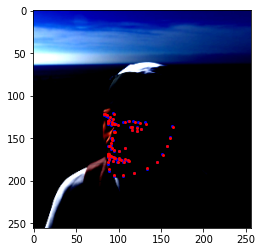

[Epoch 48/54, Batch 0/561] <Total validation loss: 0.117853> <map loss: 0.024059> <x loss: 0.022891> <y loss: 0.024344> <nbx loss: 0.023718> <nby loss: 0.022841>
[Epoch 48/54, Batch 10/561] <Total validation loss: 0.109328> <map loss: 0.021640> <x loss: 0.022394> <y loss: 0.021485> <nbx loss: 0.022440> <nby loss: 0.021370>
[Epoch 48/54, Batch 20/561] <Total validation loss: 0.109833> <map loss: 0.021739> <x loss: 0.022103> <y loss: 0.021719> <nbx loss: 0.023196> <nby loss: 0.021076>
[Epoch 48/54, Batch 30/561] <Total validation loss: 0.108279> <map loss: 0.023305> <x loss: 0.021477> <y loss: 0.020815> <nbx loss: 0.022293> <nby loss: 0.020390>
[Epoch 48/54, Batch 40/561] <Total validation loss: 0.104984> <map loss: 0.023601> <x loss: 0.020824> <y loss: 0.019597> <nbx loss: 0.021595> <nby loss: 0.019366>
[Epoch 48/54, Batch 50/561] <Total validation loss: 0.109896> <map loss: 0.025419> <x loss: 0.021288> <y loss: 0.021352> <nbx loss: 0.020876> <nby loss: 0.020962>
[Epoch 48/54, Batch 60/

NME:  0.02380406937916221


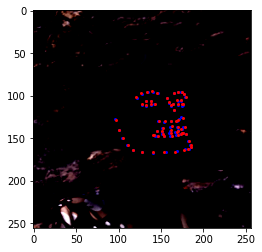

[Epoch 49/54, Batch 0/561] <Total validation loss: 0.110164> <map loss: 0.021935> <x loss: 0.022485> <y loss: 0.021257> <nbx loss: 0.023200> <nby loss: 0.021288>
[Epoch 49/54, Batch 10/561] <Total validation loss: 0.122173> <map loss: 0.025464> <x loss: 0.024126> <y loss: 0.024270> <nbx loss: 0.024598> <nby loss: 0.023715>
[Epoch 49/54, Batch 20/561] <Total validation loss: 0.108544> <map loss: 0.022541> <x loss: 0.022009> <y loss: 0.020685> <nbx loss: 0.022624> <nby loss: 0.020685>
[Epoch 49/54, Batch 30/561] <Total validation loss: 0.113523> <map loss: 0.025094> <x loss: 0.022703> <y loss: 0.021666> <nbx loss: 0.022515> <nby loss: 0.021545>
[Epoch 49/54, Batch 40/561] <Total validation loss: 0.113589> <map loss: 0.025314> <x loss: 0.024015> <y loss: 0.020280> <nbx loss: 0.023254> <nby loss: 0.020726>
[Epoch 49/54, Batch 50/561] <Total validation loss: 0.109944> <map loss: 0.023975> <x loss: 0.021336> <y loss: 0.020962> <nbx loss: 0.022107> <nby loss: 0.021563>
[Epoch 49/54, Batch 60/

NME:  0.017264921031792297


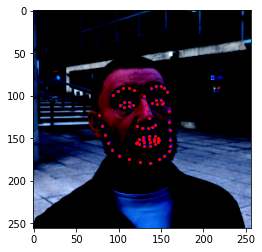

[Epoch 50/54, Batch 0/561] <Total validation loss: 0.113042> <map loss: 0.023305> <x loss: 0.023604> <y loss: 0.020858> <nbx loss: 0.024465> <nby loss: 0.020810>
[Epoch 50/54, Batch 10/561] <Total validation loss: 0.107346> <map loss: 0.022676> <x loss: 0.021669> <y loss: 0.020619> <nbx loss: 0.022279> <nby loss: 0.020103>
[Epoch 50/54, Batch 20/561] <Total validation loss: 0.103633> <map loss: 0.020879> <x loss: 0.020948> <y loss: 0.020165> <nbx loss: 0.021612> <nby loss: 0.020029>
[Epoch 50/54, Batch 30/561] <Total validation loss: 0.111346> <map loss: 0.023501> <x loss: 0.022990> <y loss: 0.020514> <nbx loss: 0.024087> <nby loss: 0.020254>
[Epoch 50/54, Batch 40/561] <Total validation loss: 0.110415> <map loss: 0.023224> <x loss: 0.020864> <y loss: 0.022398> <nbx loss: 0.021298> <nby loss: 0.022630>
[Epoch 50/54, Batch 50/561] <Total validation loss: 0.103337> <map loss: 0.021721> <x loss: 0.019404> <y loss: 0.020897> <nbx loss: 0.020541> <nby loss: 0.020773>
[Epoch 50/54, Batch 60/

NME:  0.01962021338867549


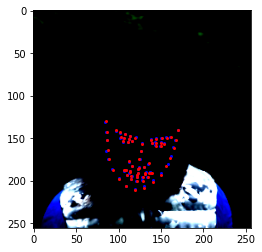

[Epoch 51/54, Batch 0/561] <Total validation loss: 0.111715> <map loss: 0.021472> <x loss: 0.022632> <y loss: 0.022080> <nbx loss: 0.023648> <nby loss: 0.021883>
[Epoch 51/54, Batch 10/561] <Total validation loss: 0.118431> <map loss: 0.021722> <x loss: 0.025006> <y loss: 0.023706> <nbx loss: 0.024612> <nby loss: 0.023385>
[Epoch 51/54, Batch 20/561] <Total validation loss: 0.109724> <map loss: 0.022275> <x loss: 0.021705> <y loss: 0.021470> <nbx loss: 0.022282> <nby loss: 0.021992>
[Epoch 51/54, Batch 30/561] <Total validation loss: 0.104399> <map loss: 0.021815> <x loss: 0.020330> <y loss: 0.020421> <nbx loss: 0.020808> <nby loss: 0.021025>
[Epoch 51/54, Batch 40/561] <Total validation loss: 0.108307> <map loss: 0.021585> <x loss: 0.021235> <y loss: 0.021651> <nbx loss: 0.022134> <nby loss: 0.021702>
[Epoch 51/54, Batch 50/561] <Total validation loss: 0.111396> <map loss: 0.022683> <x loss: 0.022794> <y loss: 0.021200> <nbx loss: 0.022943> <nby loss: 0.021777>
[Epoch 51/54, Batch 60/

NME:  0.022871659144004707


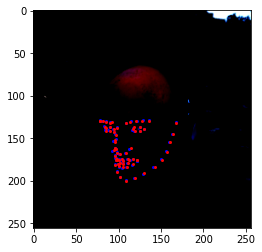

[Epoch 52/54, Batch 0/561] <Total validation loss: 0.111745> <map loss: 0.022296> <x loss: 0.022796> <y loss: 0.022077> <nbx loss: 0.022561> <nby loss: 0.022015>
[Epoch 52/54, Batch 10/561] <Total validation loss: 0.125527> <map loss: 0.022338> <x loss: 0.024803> <y loss: 0.025466> <nbx loss: 0.026269> <nby loss: 0.026651>
[Epoch 52/54, Batch 20/561] <Total validation loss: 0.108686> <map loss: 0.022919> <x loss: 0.021171> <y loss: 0.021585> <nbx loss: 0.021901> <nby loss: 0.021109>
[Epoch 52/54, Batch 30/561] <Total validation loss: 0.105644> <map loss: 0.021750> <x loss: 0.020131> <y loss: 0.021665> <nbx loss: 0.020857> <nby loss: 0.021241>
[Epoch 52/54, Batch 40/561] <Total validation loss: 0.118775> <map loss: 0.026724> <x loss: 0.021826> <y loss: 0.022901> <nbx loss: 0.023635> <nby loss: 0.023689>
[Epoch 52/54, Batch 50/561] <Total validation loss: 0.124425> <map loss: 0.025322> <x loss: 0.024471> <y loss: 0.024855> <nbx loss: 0.025080> <nby loss: 0.024698>
[Epoch 52/54, Batch 60/

NME:  0.01460016740838545


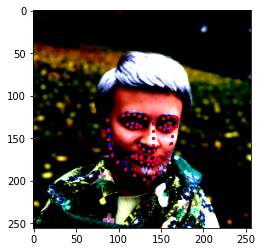

[Epoch 53/54, Batch 0/561] <Total validation loss: 0.106105> <map loss: 0.022689> <x loss: 0.021111> <y loss: 0.020252> <nbx loss: 0.021240> <nby loss: 0.020813>
[Epoch 53/54, Batch 10/561] <Total validation loss: 0.111315> <map loss: 0.023800> <x loss: 0.023492> <y loss: 0.019446> <nbx loss: 0.024347> <nby loss: 0.020229>
[Epoch 53/54, Batch 20/561] <Total validation loss: 0.105845> <map loss: 0.021988> <x loss: 0.022351> <y loss: 0.019747> <nbx loss: 0.022348> <nby loss: 0.019410>
[Epoch 53/54, Batch 30/561] <Total validation loss: 0.116852> <map loss: 0.023365> <x loss: 0.023608> <y loss: 0.023258> <nbx loss: 0.023412> <nby loss: 0.023209>
[Epoch 53/54, Batch 40/561] <Total validation loss: 0.115126> <map loss: 0.023904> <x loss: 0.023060> <y loss: 0.022186> <nbx loss: 0.024216> <nby loss: 0.021759>
[Epoch 53/54, Batch 50/561] <Total validation loss: 0.104119> <map loss: 0.021064> <x loss: 0.021180> <y loss: 0.019673> <nbx loss: 0.021610> <nby loss: 0.020591>
[Epoch 53/54, Batch 60/

NME:  0.06355006946454671


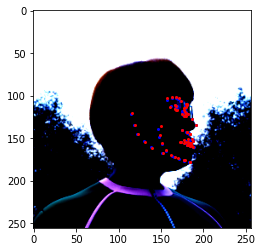

[Epoch 54/54, Batch 0/561] <Total validation loss: 0.107666> <map loss: 0.021439> <x loss: 0.020418> <y loss: 0.021576> <nbx loss: 0.022041> <nby loss: 0.022192>
[Epoch 54/54, Batch 10/561] <Total validation loss: 0.107497> <map loss: 0.021944> <x loss: 0.021546> <y loss: 0.021556> <nbx loss: 0.021435> <nby loss: 0.021017>
[Epoch 54/54, Batch 20/561] <Total validation loss: 0.117257> <map loss: 0.024119> <x loss: 0.024195> <y loss: 0.022606> <nbx loss: 0.023802> <nby loss: 0.022535>
[Epoch 54/54, Batch 30/561] <Total validation loss: 0.107183> <map loss: 0.024601> <x loss: 0.019692> <y loss: 0.020949> <nbx loss: 0.020108> <nby loss: 0.021834>
[Epoch 54/54, Batch 40/561] <Total validation loss: 0.103752> <map loss: 0.021992> <x loss: 0.019916> <y loss: 0.020455> <nbx loss: 0.020537> <nby loss: 0.020851>
[Epoch 54/54, Batch 50/561] <Total validation loss: 0.101607> <map loss: 0.022176> <x loss: 0.020306> <y loss: 0.019016> <nbx loss: 0.020106> <nby loss: 0.020004>
[Epoch 54/54, Batch 60/

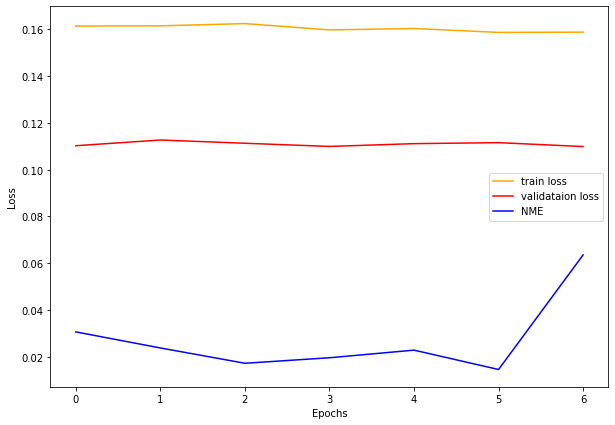

Pip_resnet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (sigmoid): Sigmoid()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
#@title Training:

load_weights = True

# directory initiation:
if not os.path.exists(os.path.join(cfg.log_dir, cfg.data_name)):
    os.mkdir(os.path.join(cfg.log_dir, cfg.data_name))

save_dir = os.path.join(cfg.log_dir, cfg.data_name, cfg.experiment_name)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

if not os.path.exists(os.path.join(save_dir, '/logs/')):
    os.mkdir(os.path.join(save_dir, '/logs/'))

log_dir = os.path.join(save_dir, '/logs/', cfg.experiment_name)
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

# logging:
logging.basicConfig(filename=os.path.join(log_dir, 'train.log'), level=logging.INFO)


meanface_indices, reverse_index1, reverse_index2, max_len = get_meanface('meanface.txt', cfg.num_nb)

if cfg.backbone == 'resnet18':
  resnet18 = models.resnet18(pretrained=cfg.pretrained)
  net = Pip_resnet18(resnet18, cfg.num_nb, num_lms=cfg.num_lms, input_size=cfg.input_size, net_stride=cfg.net_stride)
  if (load_weights):
    weight_file = 'drive/MyDrive/epoch47.pth'
    state_dict = torch.load(weight_file)
    net.load_state_dict(state_dict)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
net = net.to(device)

criterion_cls = None
if cfg.criterion_cls == 'l2':
    criterion_cls = nn.MSELoss()
elif cfg.criterion_cls == 'l1':
    criterion_cls = nn.L1Loss()

criterion_reg = None
if cfg.criterion_reg == 'l1':
    criterion_reg = nn.L1Loss()
elif cfg.criterion_reg == 'l2':
    criterion_reg = nn.MSELoss()


normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

if cfg.pretrained:  
    optimizer = optim.Adam(net.parameters(), lr=cfg.init_lr)
else:
    optimizer = optim.Adam(net.parameters(), lr=cfg.init_lr, weight_decay=5e-4)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=cfg.decay_steps, gamma=0.1)

labels_train = get_label("data_annotated.txt")
labels_validate = get_label("data_annotated_validation.txt")

if cfg.det_head == 'pip':
    train_data = ImageFolder_pip(cfg.data_dir, 
                            labels_train, cfg.input_size, cfg.num_lms, 
                            cfg.net_stride, meanface_indices, True,
                            transforms.Compose([
                            transforms.RandomGrayscale(0.2),
                            transforms.Resize(cfg.input_size),
                            transforms.ToTensor(),
                            normalize]))
    
    valid_data = ImageFolder_pip(cfg.data_dir, 
                            labels_validate, cfg.input_size, cfg.num_lms, 
                            cfg.net_stride, meanface_indices, False,
                            transforms.Compose([
                            #transforms.RandomGrayscale(0.2),
                            transforms.Resize(cfg.input_size),
                            transforms.ToTensor(),
                            normalize
                            ]))
    
else:
    print('No such head:', cfg.det_head)
    exit(0)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=cfg.batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=cfg.batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)


train_model(cfg.det_head, net, train_loader, valid_loader, criterion_cls, criterion_reg, cfg.cls_loss_weight, cfg.reg_loss_weight, cfg.num_nb, optimizer, cfg.num_epochs, scheduler, save_dir, cfg.save_interval, device)



True
Time taken for inference of image: 0.009318113327026367


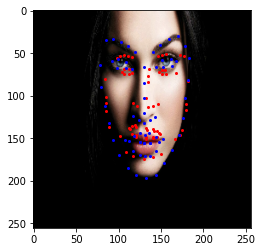

NME Value: 0.1993900740910659
Time taken for inference of image: 0.009005308151245117
Time taken for inference of image: 0.008643388748168945
Time taken for inference of image: 0.008483171463012695
Time taken for inference of image: 0.009274005889892578
Time taken for inference of image: 0.008620262145996094
Time taken for inference of image: 0.008410453796386719
Time taken for inference of image: 0.008549213409423828
Time taken for inference of image: 0.008705854415893555
Time taken for inference of image: 0.008533477783203125
Time taken for inference of image: 0.008546113967895508
Time taken for inference of image: 0.008648157119750977
Time taken for inference of image: 0.008919954299926758
Time taken for inference of image: 0.00884866714477539
Time taken for inference of image: 0.008620023727416992
Time taken for inference of image: 0.009205102920532227
Time taken for inference of image: 0.008796930313110352
Time taken for inference of image: 0.009046554565429688
Time taken for infe

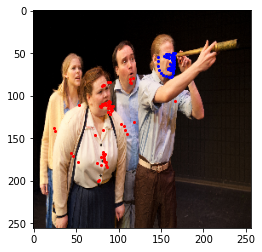

NME Value: 10.841026792028252
Time taken for inference of image: 0.010844230651855469
Time taken for inference of image: 0.00985574722290039
Time taken for inference of image: 0.00863194465637207
Time taken for inference of image: 0.014609336853027344
Time taken for inference of image: 0.008543729782104492
Time taken for inference of image: 0.008887290954589844
Time taken for inference of image: 0.008974075317382812
Time taken for inference of image: 0.009228706359863281
Time taken for inference of image: 0.008632898330688477
Time taken for inference of image: 0.009108304977416992
Time taken for inference of image: 0.009067535400390625
Time taken for inference of image: 0.008849382400512695
Time taken for inference of image: 0.008474349975585938
Time taken for inference of image: 0.008462905883789062
Time taken for inference of image: 0.008940935134887695
Time taken for inference of image: 0.00863790512084961
Time taken for inference of image: 0.00873875617980957
Time taken for inferen

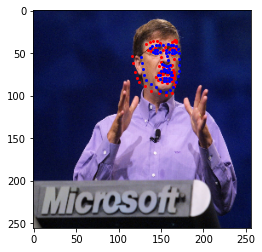

NME Value: 0.1880236780823634
Time taken for inference of image: 0.012038230895996094
Time taken for inference of image: 0.0086822509765625
Time taken for inference of image: 0.008608818054199219
Time taken for inference of image: 0.00854635238647461
Time taken for inference of image: 0.008584976196289062
Time taken for inference of image: 0.0088958740234375
Time taken for inference of image: 0.009852886199951172
Time taken for inference of image: 0.008577585220336914
Time taken for inference of image: 0.008619070053100586
Time taken for inference of image: 0.008955001831054688
Time taken for inference of image: 0.00903630256652832
Time taken for inference of image: 0.009005546569824219
Time taken for inference of image: 0.009741783142089844
Time taken for inference of image: 0.008594274520874023
Time taken for inference of image: 0.008641242980957031
Time taken for inference of image: 0.008517980575561523
Time taken for inference of image: 0.008679628372192383
Time taken for inference

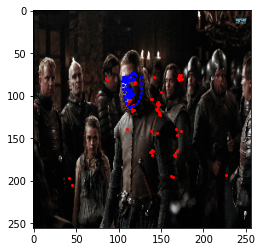

NME Value: 3.5461465583970577
Time taken for inference of image: 0.009093523025512695
Time taken for inference of image: 0.008503437042236328
Time taken for inference of image: 0.00838923454284668
Time taken for inference of image: 0.00852346420288086
Time taken for inference of image: 0.009050607681274414
Time taken for inference of image: 0.009104728698730469
Time taken for inference of image: 0.008692502975463867
Time taken for inference of image: 0.008462905883789062
Time taken for inference of image: 0.008746147155761719
Time taken for inference of image: 0.008748769760131836
Time taken for inference of image: 0.008840322494506836
Time taken for inference of image: 0.009088993072509766
Time taken for inference of image: 0.010822772979736328
Time taken for inference of image: 0.008585929870605469
Time taken for inference of image: 0.008480548858642578
Time taken for inference of image: 0.010507345199584961
Time taken for inference of image: 0.009618520736694336
Time taken for infer

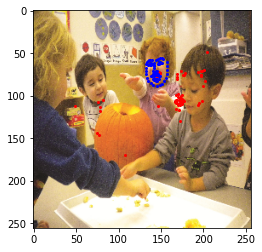

NME Value: 2.2933287176777184
Time taken for inference of image: 0.009331464767456055
Time taken for inference of image: 0.00853419303894043
Time taken for inference of image: 0.008565664291381836
Time taken for inference of image: 0.008593320846557617
Time taken for inference of image: 0.008421659469604492
Time taken for inference of image: 0.008981704711914062
Time taken for inference of image: 0.009152889251708984
Time taken for inference of image: 0.008814334869384766
Time taken for inference of image: 0.008638858795166016
Time taken for inference of image: 0.008749008178710938
Time taken for inference of image: 0.008816957473754883
Time taken for inference of image: 0.009053945541381836
Time taken for inference of image: 0.008790731430053711
Time taken for inference of image: 0.008704423904418945
Time taken for inference of image: 0.008861541748046875
Time taken for inference of image: 0.011444330215454102
Time taken for inference of image: 0.008722543716430664
Time taken for infe

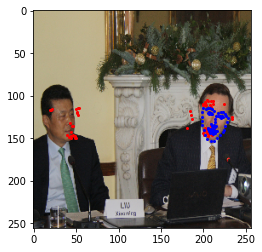

NME Value: 3.46832586165036
Time taken for inference of image: 0.01043081283569336
Time taken for inference of image: 0.00898432731628418
Time taken for inference of image: 0.009105443954467773
Time taken for inference of image: 0.008878469467163086
Time taken for inference of image: 0.008713245391845703
Time taken for inference of image: 0.010408639907836914
Time taken for inference of image: 0.00893259048461914
Time taken for inference of image: 0.008532047271728516
Time taken for inference of image: 0.009294271469116211
Time taken for inference of image: 0.008722066879272461
Time taken for inference of image: 0.008553743362426758
Time taken for inference of image: 0.008907079696655273
Time taken for inference of image: 0.008739709854125977
Time taken for inference of image: 0.008978843688964844
Time taken for inference of image: 0.008874177932739258
Time taken for inference of image: 0.010021448135375977
Time taken for inference of image: 0.008729934692382812
Time taken for inferenc

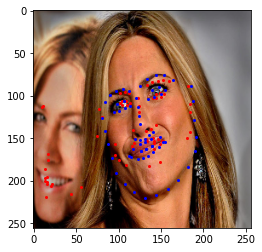

NME Value: 0.3873697434024939
Time taken for inference of image: 0.009003400802612305
Time taken for inference of image: 0.008634328842163086
Time taken for inference of image: 0.008554697036743164
Time taken for inference of image: 0.009137392044067383
Time taken for inference of image: 0.00889134407043457
Time taken for inference of image: 0.008816003799438477
Time taken for inference of image: 0.008852005004882812
Time taken for inference of image: 0.00851583480834961
Time taken for inference of image: 0.009112834930419922
Time taken for inference of image: 0.009136438369750977
Time taken for inference of image: 0.0090179443359375
Time taken for inference of image: 0.008541584014892578
Time taken for inference of image: 0.008936643600463867
Time taken for inference of image: 0.009171247482299805
Time taken for inference of image: 0.008513212203979492
Time taken for inference of image: 0.008620023727416992
Time taken for inference of image: 0.008707761764526367
Time taken for inferen

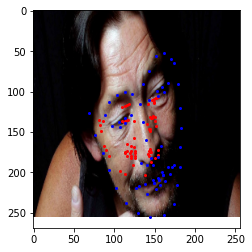

NME Value: 0.3927030790843218
Time taken for inference of image: 0.009000539779663086
Time taken for inference of image: 0.011145591735839844
Time taken for inference of image: 0.010331869125366211
Time taken for inference of image: 0.010161638259887695
Time taken for inference of image: 0.009908437728881836
Time taken for inference of image: 0.010125160217285156
Time taken for inference of image: 0.009780406951904297
Time taken for inference of image: 0.010079383850097656
Time taken for inference of image: 0.01446843147277832
Time taken for inference of image: 0.010026693344116211
Time taken for inference of image: 0.010079383850097656
Time taken for inference of image: 0.009831666946411133
Time taken for inference of image: 0.010167360305786133
Time taken for inference of image: 0.009629011154174805
Time taken for inference of image: 0.009755134582519531
Time taken for inference of image: 0.010328292846679688
Time taken for inference of image: 0.013295173645019531
Time taken for infe

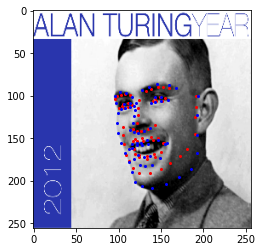

NME Value: 0.12131438492474662
Time taken for inference of image: 0.010308504104614258
Time taken for inference of image: 0.010013341903686523
Time taken for inference of image: 0.011817693710327148
Time taken for inference of image: 0.00989675521850586
Time taken for inference of image: 0.009735584259033203
Time taken for inference of image: 0.009744882583618164
Time taken for inference of image: 0.010492563247680664
Time taken for inference of image: 0.010270357131958008
Time taken for inference of image: 0.016533851623535156
Time taken for inference of image: 0.010640859603881836
Time taken for inference of image: 0.01073145866394043
Time taken for inference of image: 0.011078834533691406
Time taken for inference of image: 0.011248111724853516
Time taken for inference of image: 0.011291265487670898
Time taken for inference of image: 0.010723352432250977
Time taken for inference of image: 0.010103702545166016
Time taken for inference of image: 0.011119842529296875
Time taken for infe

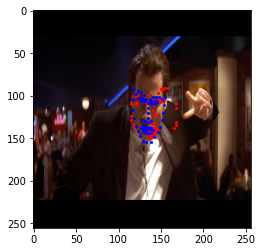

NME Value: 0.3681785197229315
Time taken for inference of image: 0.01123046875
Time taken for inference of image: 0.008553743362426758
Time taken for inference of image: 0.009829998016357422
Time taken for inference of image: 0.008514165878295898
Time taken for inference of image: 0.008504390716552734
Time taken for inference of image: 0.008519411087036133
Time taken for inference of image: 0.008592367172241211
Time taken for inference of image: 0.00857090950012207
Time taken for inference of image: 0.00880289077758789
Time taken for inference of image: 0.008595705032348633
Time taken for inference of image: 0.008946895599365234
Time taken for inference of image: 0.008958578109741211
Time taken for inference of image: 0.00872802734375
Time taken for inference of image: 0.008582830429077148
Time taken for inference of image: 0.00858759880065918
Time taken for inference of image: 0.008986711502075195
Time taken for inference of image: 0.008611917495727539
Time taken for inference of imag

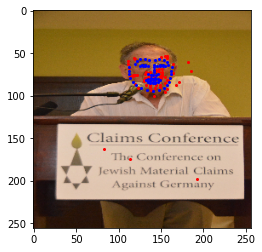

NME Value: 0.39371550775114245
Time taken for inference of image: 0.010213851928710938
Time taken for inference of image: 0.011250019073486328
Time taken for inference of image: 0.008916139602661133
Time taken for inference of image: 0.009035348892211914
Time taken for inference of image: 0.00902104377746582
Time taken for inference of image: 0.010643720626831055
Time taken for inference of image: 0.008912324905395508
Time taken for inference of image: 0.009042024612426758
Time taken for inference of image: 0.008942365646362305
Time taken for inference of image: 0.008556604385375977
Time taken for inference of image: 0.008963346481323242
Time taken for inference of image: 0.00853419303894043
Time taken for inference of image: 0.008498907089233398
Time taken for inference of image: 0.008934736251831055
Time taken for inference of image: 0.00879049301147461
Time taken for inference of image: 0.008405923843383789
Time taken for inference of image: 0.008889436721801758
Time taken for infer

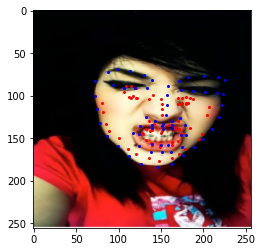

NME Value: 0.11564432636738418
Time taken for inference of image: 0.009122848510742188
Time taken for inference of image: 0.008991718292236328
Time taken for inference of image: 0.008634328842163086
Time taken for inference of image: 0.008547067642211914
Time taken for inference of image: 0.00886392593383789
Time taken for inference of image: 0.008555412292480469
Time taken for inference of image: 0.00930166244506836
Time taken for inference of image: 0.009023427963256836
Time taken for inference of image: 0.009017467498779297
Time taken for inference of image: 0.008900880813598633
Time taken for inference of image: 0.009116411209106445
Time taken for inference of image: 0.010924100875854492
Time taken for inference of image: 0.009190797805786133
Time taken for inference of image: 0.009413957595825195
Time taken for inference of image: 0.009246110916137695
Time taken for inference of image: 0.009034395217895508
Time taken for inference of image: 0.00910639762878418
Time taken for infer

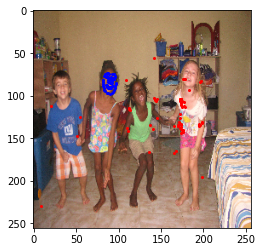

NME Value: 7.1219251023383885
Time taken for inference of image: 0.00997614860534668
Time taken for inference of image: 0.010716438293457031
Time taken for inference of image: 0.008812427520751953
Time taken for inference of image: 0.009059667587280273
Time taken for inference of image: 0.008721351623535156
Time taken for inference of image: 0.011060714721679688
Time taken for inference of image: 0.00907588005065918
Time taken for inference of image: 0.008976221084594727
Time taken for inference of image: 0.008574247360229492
Time taken for inference of image: 0.008491277694702148
Time taken for inference of image: 0.008637666702270508
Time taken for inference of image: 0.008850574493408203
Time taken for inference of image: 0.009009838104248047
Time taken for inference of image: 0.009326934814453125
Time taken for inference of image: 0.008608818054199219
Time taken for inference of image: 0.008678674697875977
Time taken for inference of image: 0.00891876220703125
Time taken for infere

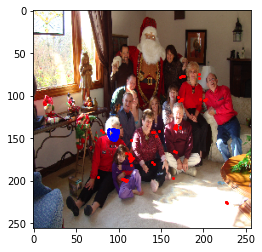

NME Value: 9.380634965210156
Time taken for inference of image: 0.009165287017822266
Time taken for inference of image: 0.008660554885864258
Time taken for inference of image: 0.008935213088989258
Time taken for inference of image: 0.008521795272827148
Time taken for inference of image: 0.00862264633178711
Time taken for inference of image: 0.008502006530761719
Time taken for inference of image: 0.00903630256652832
Time taken for inference of image: 0.008657693862915039
Time taken for inference of image: 0.00858449935913086
Time taken for inference of image: 0.008516788482666016
Time taken for inference of image: 0.008777618408203125
Time taken for inference of image: 0.008761405944824219
Time taken for inference of image: 0.009464263916015625
Time taken for inference of image: 0.008522987365722656
Time taken for inference of image: 0.009424924850463867
Time taken for inference of image: 0.008693695068359375
Time taken for inference of image: 0.008558988571166992
Time taken for inferen

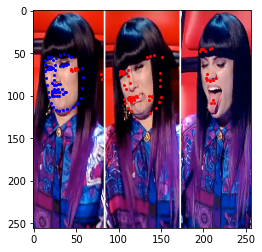

NME Value: 4.002729523410598
Time taken for inference of image: 0.008907556533813477
Time taken for inference of image: 0.00890207290649414
Time taken for inference of image: 0.009160757064819336
Time taken for inference of image: 0.008559942245483398
Time taken for inference of image: 0.008472919464111328
Time taken for inference of image: 0.008897066116333008
Time taken for inference of image: 0.00861668586730957
Time taken for inference of image: 0.008470296859741211
Time taken for inference of image: 0.008749961853027344
Time taken for inference of image: 0.008569478988647461
Time taken for inference of image: 0.008494853973388672
Time taken for inference of image: 0.008930444717407227
Time taken for inference of image: 0.009724140167236328
Time taken for inference of image: 0.008481979370117188
Time taken for inference of image: 0.008515596389770508
Time taken for inference of image: 0.008516073226928711
Time taken for inference of image: 0.009002685546875
Time taken for inference

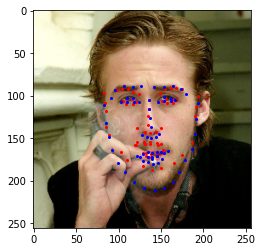

NME Value: 0.17238202153217946
Time taken for inference of image: 0.010910749435424805
Time taken for inference of image: 0.008969783782958984
Time taken for inference of image: 0.010994911193847656
Time taken for inference of image: 0.008847951889038086
Time taken for inference of image: 0.008545637130737305
Time taken for inference of image: 0.009503602981567383
Time taken for inference of image: 0.009044647216796875
Time taken for inference of image: 0.009237527847290039
Time taken for inference of image: 0.009217262268066406
Time taken for inference of image: 0.009276390075683594
Time taken for inference of image: 0.009033441543579102
Time taken for inference of image: 0.008902788162231445
Time taken for inference of image: 0.008614778518676758
Time taken for inference of image: 0.010819673538208008
Time taken for inference of image: 0.00856637954711914
Time taken for inference of image: 0.0087432861328125
Time taken for inference of image: 0.008751392364501953
Time taken for infer

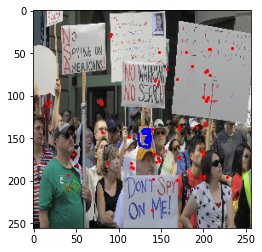

NME Value: 4.532142281623595
Time taken for inference of image: 0.009879827499389648
Time taken for inference of image: 0.008949756622314453
Time taken for inference of image: 0.009009122848510742
Time taken for inference of image: 0.008548259735107422
Time taken for inference of image: 0.008919239044189453
Time taken for inference of image: 0.008948802947998047
Time taken for inference of image: 0.008649826049804688
Time taken for inference of image: 0.00876474380493164
Time taken for inference of image: 0.008901119232177734
Time taken for inference of image: 0.008666753768920898
Time taken for inference of image: 0.009137630462646484
Time taken for inference of image: 0.010145902633666992
Time taken for inference of image: 0.008966684341430664
Time taken for inference of image: 0.01026463508605957
Time taken for inference of image: 0.008616447448730469
Time taken for inference of image: 0.009634971618652344
Time taken for inference of image: 0.008733034133911133
Time taken for infere

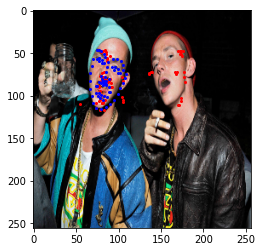

NME Value: 0.9628585812715532
Time taken for inference of image: 0.010168075561523438
Time taken for inference of image: 0.00894474983215332
Time taken for inference of image: 0.008725881576538086
Time taken for inference of image: 0.008719205856323242
Time taken for inference of image: 0.008756160736083984
Time taken for inference of image: 0.008758783340454102
Time taken for inference of image: 0.010414838790893555
Time taken for inference of image: 0.008558988571166992
Time taken for inference of image: 0.009062767028808594
Time taken for inference of image: 0.008643865585327148
Time taken for inference of image: 0.008866548538208008
Time taken for inference of image: 0.010071039199829102
Time taken for inference of image: 0.009042739868164062
Time taken for inference of image: 0.008867025375366211
Time taken for inference of image: 0.009006738662719727
Time taken for inference of image: 0.008713006973266602
Time taken for inference of image: 0.009054183959960938
Time taken for infe

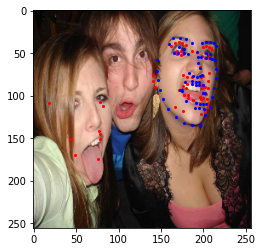

NME Value: 0.4789708522707155
Time taken for inference of image: 0.010492563247680664
Time taken for inference of image: 0.01242828369140625
Time taken for inference of image: 0.008948564529418945
Time taken for inference of image: 0.009021997451782227
Time taken for inference of image: 0.009531736373901367
Time taken for inference of image: 0.009007930755615234
Time taken for inference of image: 0.008996248245239258
Time taken for inference of image: 0.008969545364379883
Time taken for inference of image: 0.00870060920715332
Time taken for inference of image: 0.009026288986206055
Time taken for inference of image: 0.008700370788574219
Time taken for inference of image: 0.009099006652832031
Time taken for inference of image: 0.009004592895507812
Time taken for inference of image: 0.008739471435546875
Time taken for inference of image: 0.008567094802856445
Time taken for inference of image: 0.010769128799438477
Time taken for inference of image: 0.01031804084777832
Time taken for infere

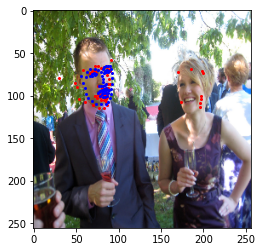

NME Value: 0.8868987993637507
Time taken for inference of image: 0.01000070571899414
Time taken for inference of image: 0.009843587875366211
Time taken for inference of image: 0.01229715347290039
Time taken for inference of image: 0.014095544815063477
Time taken for inference of image: 0.011103153228759766
Time taken for inference of image: 0.010414838790893555
Time taken for inference of image: 0.01017141342163086
Time taken for inference of image: 0.011277914047241211
Time taken for inference of image: 0.009821891784667969
Time taken for inference of image: 0.01026296615600586
Time taken for inference of image: 0.009804487228393555
Time taken for inference of image: 0.01006460189819336
Time taken for inference of image: 0.010212898254394531
Time taken for inference of image: 0.009765386581420898
Time taken for inference of image: 0.010606527328491211
Time taken for inference of image: 0.011132478713989258
Time taken for inference of image: 0.010940790176391602
Time taken for inferenc

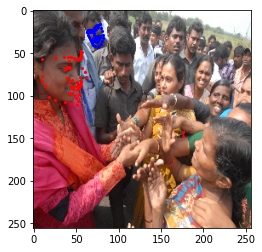

NME Value: 4.9966610080154386
Time taken for inference of image: 0.011126041412353516
Time taken for inference of image: 0.009400367736816406
Time taken for inference of image: 0.009233474731445312
Time taken for inference of image: 0.011539697647094727
Time taken for inference of image: 0.009281158447265625
Time taken for inference of image: 0.010046958923339844
Time taken for inference of image: 0.009898900985717773
Time taken for inference of image: 0.009198188781738281
Time taken for inference of image: 0.008866548538208008
Time taken for inference of image: 0.008635997772216797
Time taken for inference of image: 0.008478403091430664
Time taken for inference of image: 0.010165691375732422
Time taken for inference of image: 0.008580207824707031
Time taken for inference of image: 0.00908517837524414
Time taken for inference of image: 0.008965730667114258
Time taken for inference of image: 0.010112285614013672
Time taken for inference of image: 0.008686542510986328
Time taken for infe

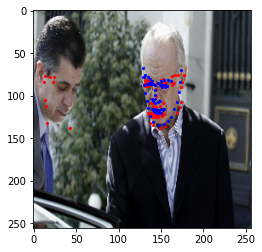

NME Value: 1.0161885532182269
Time taken for inference of image: 0.010407447814941406
Time taken for inference of image: 0.011770009994506836
Time taken for inference of image: 0.00905609130859375
Time taken for inference of image: 0.008647918701171875
Time taken for inference of image: 0.0091094970703125
Time taken for inference of image: 0.00985097885131836
Time taken for inference of image: 0.009047508239746094
Time taken for inference of image: 0.008946657180786133
Time taken for inference of image: 0.012301445007324219
Time taken for inference of image: 0.009013175964355469
Time taken for inference of image: 0.008606433868408203
Time taken for inference of image: 0.00911092758178711
Time taken for inference of image: 0.009031057357788086
Time taken for inference of image: 0.00869297981262207
Time taken for inference of image: 0.00861048698425293
Time taken for inference of image: 0.008909463882446289
Time taken for inference of image: 0.009601116180419922
Time taken for inference 

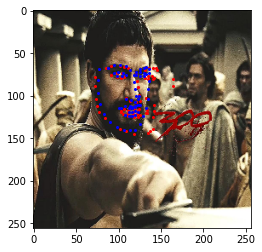

NME Value: 0.18945631372115224
Time taken for inference of image: 0.010097026824951172
Time taken for inference of image: 0.010438919067382812
Time taken for inference of image: 0.008907556533813477
Time taken for inference of image: 0.009649991989135742
Time taken for inference of image: 0.008671283721923828
Time taken for inference of image: 0.008558988571166992
Time taken for inference of image: 0.008971929550170898
Time taken for inference of image: 0.009373664855957031
Time taken for inference of image: 0.009148359298706055
Time taken for inference of image: 0.009128570556640625
Time taken for inference of image: 0.009155750274658203
Time taken for inference of image: 0.009140253067016602
Time taken for inference of image: 0.012711286544799805
Time taken for inference of image: 0.010682821273803711
Time taken for inference of image: 0.00915980339050293
Time taken for inference of image: 0.008719921112060547
Time taken for inference of image: 0.00873112678527832
Time taken for infe

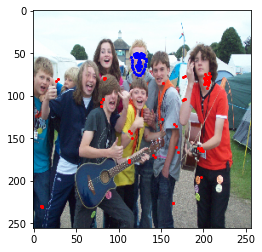

NME Value: 8.372079608485553
Time taken for inference of image: 0.008889436721801758
Time taken for inference of image: 0.009121179580688477
Time taken for inference of image: 0.008661508560180664
Time taken for inference of image: 0.009138822555541992
Time taken for inference of image: 0.008463621139526367
Time taken for inference of image: 0.008909940719604492
Time taken for inference of image: 0.01040506362915039
Time taken for inference of image: 0.01077580451965332
Time taken for inference of image: 0.008871316909790039
Time taken for inference of image: 0.009861946105957031
Time taken for inference of image: 0.00898432731628418
Time taken for inference of image: 0.008553028106689453
Time taken for inference of image: 0.00973653793334961
Time taken for inference of image: 0.00886082649230957
Time taken for inference of image: 0.009145259857177734
Time taken for inference of image: 0.008475542068481445
Time taken for inference of image: 0.00902867317199707
Time taken for inference 

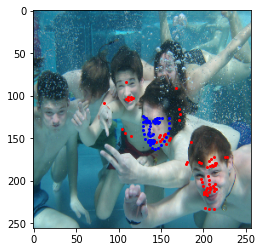

NME Value: 2.78322298377313
Time taken for inference of image: 0.009023666381835938
Time taken for inference of image: 0.008637666702270508
Time taken for inference of image: 0.009117603302001953
Time taken for inference of image: 0.009011268615722656
Time taken for inference of image: 0.00852513313293457
Time taken for inference of image: 0.008558034896850586
Time taken for inference of image: 0.009148359298706055
Time taken for inference of image: 0.009146690368652344
Time taken for inference of image: 0.009139537811279297
Time taken for inference of image: 0.009104013442993164
Time taken for inference of image: 0.008780241012573242
Time taken for inference of image: 0.008689641952514648
Time taken for inference of image: 0.008607149124145508
Time taken for inference of image: 0.010277032852172852
Time taken for inference of image: 0.009213924407958984
Time taken for inference of image: 0.008554458618164062
Time taken for inference of image: 0.009050130844116211
Time taken for infere

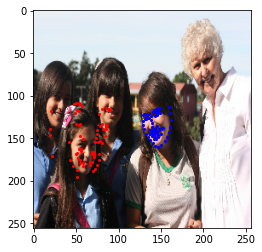

NME Value: 4.2880535413976375
Time taken for inference of image: 0.009131669998168945
Time taken for inference of image: 0.00869894027709961
Time taken for inference of image: 0.009527206420898438
Time taken for inference of image: 0.008673667907714844
Time taken for inference of image: 0.008693456649780273
Time taken for inference of image: 0.009167671203613281
Time taken for inference of image: 0.00847315788269043
Time taken for inference of image: 0.008383035659790039
Time taken for inference of image: 0.00846242904663086
Time taken for inference of image: 0.009110689163208008
Time taken for inference of image: 0.008857965469360352
Time taken for inference of image: 0.008597373962402344
Time taken for inference of image: 0.008568763732910156
Time taken for inference of image: 0.008521556854248047
Time taken for inference of image: 0.008512735366821289
Time taken for inference of image: 0.008405685424804688
Time taken for inference of image: 0.012007713317871094
Time taken for infere

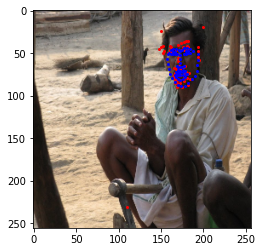

NME Value: 0.4534961884190773
Time taken for inference of image: 0.009053945541381836
Time taken for inference of image: 0.012143373489379883
Time taken for inference of image: 0.009099006652832031
Time taken for inference of image: 0.008965015411376953
Time taken for inference of image: 0.009057044982910156
Time taken for inference of image: 0.008960723876953125
Time taken for inference of image: 0.009032964706420898
Time taken for inference of image: 0.00917196273803711
Time taken for inference of image: 0.009039878845214844
Time taken for inference of image: 0.009293794631958008
Time taken for inference of image: 0.009821414947509766
Time taken for inference of image: 0.008865833282470703
Time taken for inference of image: 0.008757352828979492
Time taken for inference of image: 0.008812189102172852
Time taken for inference of image: 0.00919342041015625
Time taken for inference of image: 0.008959293365478516
Time taken for inference of image: 0.008660078048706055
Time taken for infer

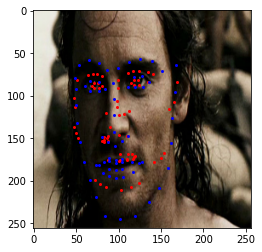

NME Value: 0.22012591782201774
Time taken for inference of image: 0.00906991958618164
Time taken for inference of image: 0.008774995803833008
Time taken for inference of image: 0.009123086929321289
Time taken for inference of image: 0.009221553802490234
Time taken for inference of image: 0.008983612060546875
Time taken for inference of image: 0.008723020553588867
Time taken for inference of image: 0.008800745010375977
Time taken for inference of image: 0.009905099868774414
Time taken for inference of image: 0.009010076522827148
Time taken for inference of image: 0.008755683898925781
Time taken for inference of image: 0.008614778518676758
Time taken for inference of image: 0.008987188339233398
Time taken for inference of image: 0.008893966674804688
Time taken for inference of image: 0.008596181869506836
Time taken for inference of image: 0.008987188339233398
Time taken for inference of image: 0.008835077285766602
Time taken for inference of image: 0.010239601135253906
Time taken for inf

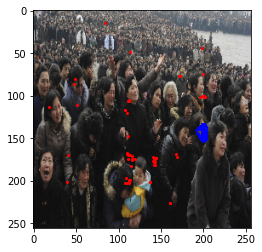

NME Value: 9.751616102722053
Time taken for inference of image: 0.010117053985595703
Time taken for inference of image: 0.009025096893310547
Time taken for inference of image: 0.009063720703125
Time taken for inference of image: 0.008971214294433594
Time taken for inference of image: 0.009144306182861328
Time taken for inference of image: 0.012059688568115234
Time taken for inference of image: 0.008960247039794922
Time taken for inference of image: 0.008919715881347656
Time taken for inference of image: 0.008792400360107422
Time taken for inference of image: 0.008526086807250977
Time taken for inference of image: 0.008962631225585938
Time taken for inference of image: 0.008646249771118164
Time taken for inference of image: 0.008855104446411133
Time taken for inference of image: 0.008722066879272461
Time taken for inference of image: 0.010776042938232422
Time taken for inference of image: 0.009679794311523438
Time taken for inference of image: 0.009094476699829102
Time taken for inferen

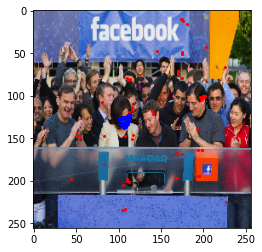

NME Value: 6.073325055391225
Time taken for inference of image: 0.010170459747314453
Time taken for inference of image: 0.009948968887329102
Time taken for inference of image: 0.010296106338500977
Time taken for inference of image: 0.01027226448059082
Time taken for inference of image: 0.010926246643066406
Time taken for inference of image: 0.01013326644897461
Time taken for inference of image: 0.01054525375366211
Time taken for inference of image: 0.010185003280639648
Time taken for inference of image: 0.010264396667480469
Time taken for inference of image: 0.009783744812011719
Time taken for inference of image: 0.010095357894897461
Time taken for inference of image: 0.01901531219482422
Time taken for inference of image: 0.012349605560302734
Time taken for inference of image: 0.010016679763793945
Time taken for inference of image: 0.01029658317565918
Time taken for inference of image: 0.009673595428466797
Time taken for inference of image: 0.010383844375610352
Time taken for inference

In [25]:
#@title Testing:
RANDOM_SEED = 13

class FaceKeypointTestDataset(Dataset):
    def __init__(self, path):
      ind_names = np.array([])
      out_names = np.array([])
      for f in os.listdir(path + "/01_Indoor"):
        if not '.pts' in f:
          ind_names = np.append(ind_names, "/01_Indoor/" + f)
      for f in os.listdir(path + "/02_Outdoor"):
        if not '.pts' in f:
          out_names = np.append(out_names, '/02_Outdoor/' + f)
      self.ind_data = ind_names
      self.out_data = out_names
      self.path = path

    def __len__(self):
        return len(self.data)

    def get_300W_item(self, name):
      pathname = self.path + name
      image = cv2.imread(pathname)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      orig_h, orig_w, channel = image.shape
      image = cv2.resize(image, (cfg.input_size, cfg.input_size))

      idx = [idx for idx, x in enumerate(pathname) if x == '.']
      keyname = pathname[0:idx[0]] + ".pts"
      keypoints = np.loadtxt(keyname, dtype=float, comments=("version:", "n_points:", "{", "}"))
      # reshape the keypoints
      keypoints.reshape(68, 2)
      # normalize keypoints:
      keypoints = keypoints * [1 / orig_w, 1 / orig_h]
      return image, keypoints
      

    def get_300W_Data(self):
      np.random.seed(RANDOM_SEED)
      np.random.shuffle(self.ind_data)
      np.random.shuffle(self.out_data)
      #use a randomized 500 ims from outdoor images and a randomized 500 from indoor images
      data = np.append(self.ind_data[0:500], self.out_data[0:500]) 
      return data



load_weights = True
weight_file = 'drive/MyDrive/machine-learning/pipnet_epoch54_train1k-augmentations:half.pth'

meanface_indices, reverse_index1, reverse_index2, max_len = get_meanface('meanface.txt', cfg.num_nb)
    
if load_weights:
  resnet18 = models.resnet18(pretrained=cfg.pretrained)
  net = Pip_resnet18(resnet18, cfg.num_nb, num_lms=cfg.num_lms, input_size=cfg.input_size, net_stride=cfg.net_stride)
  state_dict = torch.load(weight_file)
  net.load_state_dict(state_dict)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
net = net.to(device)

testdata = FaceKeypointTestDataset(cfg.test_data_dir)
dataframe = testdata.get_300W_Data()
nme = []
count = 0

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([transforms.Resize((cfg.input_size, cfg.input_size)), transforms.ToTensor(), normalize])
time_all = 0

for n in dataframe:
  image, keypoints = testdata.get_300W_item(n)

  norm = np.linalg.norm(keypoints[36] - keypoints[45])

  inputs = Image.fromarray(image[:,:,::-1].astype('uint8'), 'RGB')
  inputs = preprocess(inputs).unsqueeze(0)
  inputs = inputs.to(device)

  t1 = time.time()

  lms_pred_x, lms_pred_y, lms_pred_nb_x, lms_pred_nb_y, outputs_cls, max_cls = forward_pip(net, inputs, cfg.input_size, cfg.net_stride, cfg.num_nb)

  lms_pred = torch.cat((lms_pred_x, lms_pred_y), dim=1).flatten()
  tmp_nb_x = lms_pred_nb_x[reverse_index1, reverse_index2].view(cfg.num_lms, max_len)
  tmp_nb_y = lms_pred_nb_y[reverse_index1, reverse_index2].view(cfg.num_lms, max_len)
  tmp_x = torch.mean(torch.cat((lms_pred_x, tmp_nb_x), dim=1), dim=1).view(-1,1)
  tmp_y = torch.mean(torch.cat((lms_pred_y, tmp_nb_y), dim=1), dim=1).view(-1,1)
  lms_pred_merge = torch.cat((tmp_x, tmp_y), dim=1).flatten()

  t2 = time.time()
  time_all += (t2-t1)

  lms_pred = lms_pred.cpu().numpy()
  lms_pred_merge = lms_pred_merge.cpu().numpy()

  #nme_std = compute_nme(lms_pred, lms_gt, norm)
  #nmes_std.append(nme_std)
  lms_gt = np.reshape(keypoints, (1,keypoints.shape[0]*2))
  lms_gt = lms_gt[0]
  #print(lms_pred_merge.shape)
  #print(lms_gt.shape)
  nme_merge = compute_nme(lms_pred_merge, lms_gt, norm)
  nme.append(nme_merge)

  preds = np.reshape(lms_pred, (len(lms_pred)//2, 2))
  truths = np.reshape(lms_gt, (len(lms_gt)//2, 2))

  print("Time taken for inference of image: " + str(t2-t1))

  if count % 20 == 0:
    plt.imshow(image)
    plt.plot(preds[:,0]*cfg.input_size,preds[:,1]*cfg.input_size, 'ro', markersize = 2)
    plt.plot(truths[:,0]*cfg.input_size,truths[:,1]*cfg.input_size, 'bo', markersize = 2)
    plt.show()  
    print("NME Value: " + str(nme_merge));

  count += 1


nme = np.array(nme)
print("Average NME: " + str(np.mean(nme)))
print("Total Time: " + str(time_all))

In [ ]:
#@title Video Test

meanface_indices, reverse_index1, reverse_index2, max_len = get_meanface(os.path.join('meanface.txt'), cfg.num_nb)


#if cfg.backbone == 'resnet18':
#    resnet18 = models.resnet18(pretrained=cfg.pretrained)
#    net = Pip_resnet18(resnet18, cfg.num_nb, num_lms=cfg.num_lms, input_size=cfg.input_size, net_stride=cfg.net_stride)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

#weight_file = os.path.join(save_dir, 'epoch%d.pth' % (cfg.num_epochs-1))
#state_dict = torch.load(weight_file, map_location=device)
#net.load_state_dict(state_dict)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([transforms.Resize((cfg.input_size, cfg.input_size)), transforms.ToTensor(), normalize])

def demo_video(video_file, net, preprocess, input_size, net_stride, num_nb, use_gpu, device):
    #detector = FaceBoxesDetector('FaceBoxes', 'FaceBoxesV2/weights/FaceBoxesV2.pth', use_gpu, device)
    my_thresh = 0.9
    det_box_scale = 1.2

    net.eval()
    if video_file == 'camera':
        cap = cv2.VideoCapture(0)
    else:
        cap = cv2.VideoCapture(video_file)
    if (cap.isOpened()== False): 
        print("Error opening video stream or file")
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    count = 0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            inputs = Image.fromarray(frame[:,:,::-1].astype('uint8'), 'RGB')
            inputs = preprocess(inputs).unsqueeze(0)
            inputs = inputs.to(device)
            lms_pred_x, lms_pred_y, lms_pred_nb_x, lms_pred_nb_y, outputs_cls, max_cls = forward_pip(net, inputs, input_size, net_stride, num_nb)
            lms_pred = torch.cat((lms_pred_x, lms_pred_y), dim=1).flatten()
            tmp_nb_x = lms_pred_nb_x[reverse_index1, reverse_index2].view(cfg.num_lms, max_len)
            tmp_nb_y = lms_pred_nb_y[reverse_index1, reverse_index2].view(cfg.num_lms, max_len)
            tmp_x = torch.mean(torch.cat((lms_pred_x, tmp_nb_x), dim=1), dim=1).view(-1,1)
            tmp_y = torch.mean(torch.cat((lms_pred_y, tmp_nb_y), dim=1), dim=1).view(-1,1)
            lms_pred_merge = torch.cat((tmp_x, tmp_y), dim=1).flatten()
            lms_pred = lms_pred.cpu().numpy()
            lms_pred_merge = lms_pred_merge.cpu().numpy()
            for i in range(cfg.num_lms):
                x_pred = lms_pred_merge[i*2]*frame_width
                y_pred = lms_pred_merge[i*2+1]*frame_height
                cv2.circle(frame, (int(x_pred), int(y_pred)), 1, (0, 0, 255), 2)
                
            count += 1
            cv2.imwrite('drive/MyDrive/test-video-frames/'+str(count)+'.jpg', frame)
            #cv2.imshow('1', frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            break

    cap.release()
    cv2.destroyAllWindows()

video_file = 'drive/MyDrive/007.avi'



demo_video(video_file, net, preprocess, cfg.input_size, cfg.net_stride, cfg.num_nb, cfg.use_gpu, device)


<ipython-input-9-9379ba8c1b38>:236: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  tmp_y = (max_ids//tmp_width).view(-1,1).float()+outputs_y_select.view(-1,1)
<ipython-input-9-9379ba8c1b38>:241: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  tmp_nb_y = (max_ids//tmp_width).view(-1,1).float()+outputs_nb_y_select


In [ ]:
cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    frame = cv2.cvtColor(src=frame, code=cv2.COLOR_BGR2RGB)
    cv2.imshow('webcam', frame)
# press escape to exit
    if (cv2.waitKey(30) == 27):
       break
cap.release()
cv2.destroyAllWindows()